# 1. 모델 설계

In [1]:
## 필요한 패키지 Import
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
print(device)

data_dir = ''

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

cuda:0
238 276


train/10.jpg


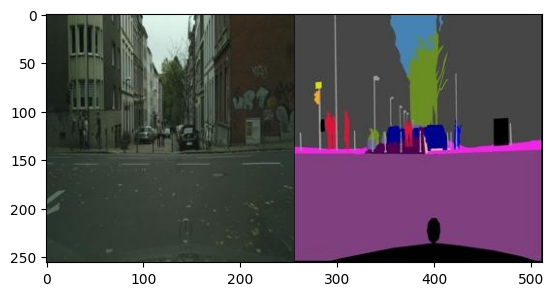

In [2]:
## 샘플 이미지 검색
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp)
plt.imshow(sample_image)
print(sample_image_fp)

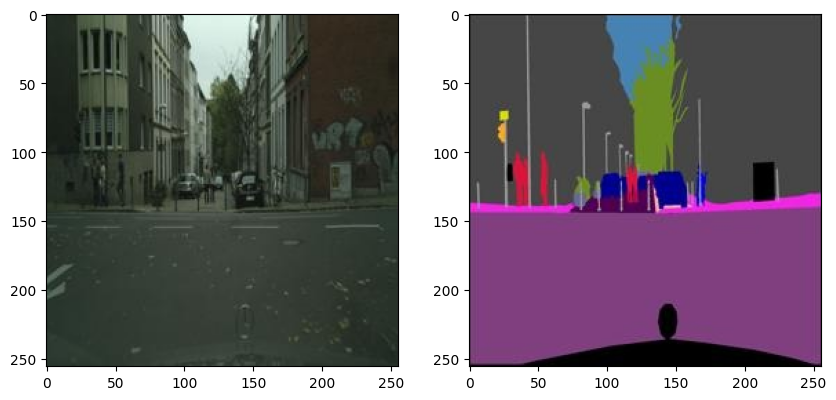

In [3]:
# 이미지 분리 함수 정의
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [4]:
## 임의의 수 지정
num_items = 1000
## 0 ~ 255 사이의 숫자를 3 * num_items 번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [5]:
num_classes = 10

## K-means Clustering 알고리즘을 사용해 label_model 에 저장
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

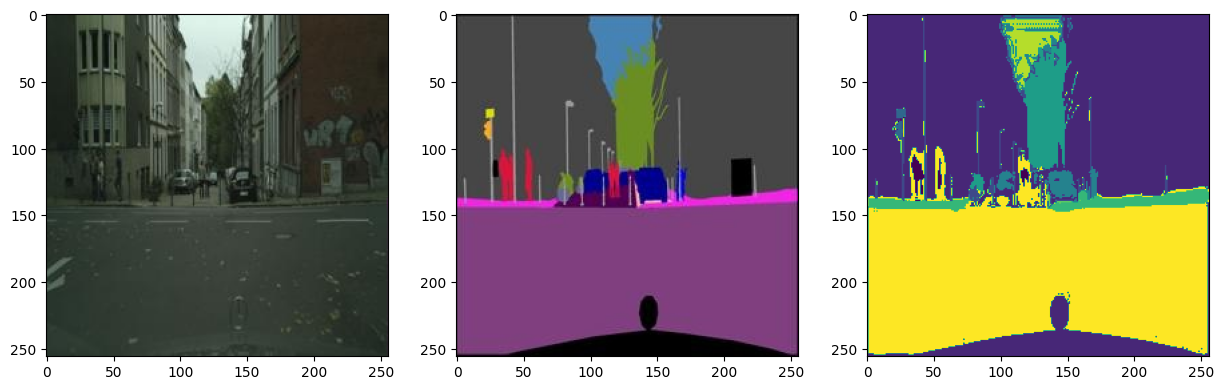

In [6]:
## 이미지, 라벨, 라벨에 대해 모델이 예측 
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [7]:
## Dataset 정의하기
class CityscapeDataset(Dataset):

  ## 이미지 디렉토리와 모델이 정의한 라벨 정의하기
  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  ## 이미지 개수 알아보는 함수 정의하기
  def __len__(self):
    return len(self.image_fns)

## 데이터를 이미지와 라벨로 분할하는 함수 정의하기
  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

## 이미지 텐서로 변환하고 정규화하는 함수 정의하기
  def transform(self, image):
    transform_ops = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

  ## 인덱스를 통해 이미지를 가져오는 함수 정의하기
  def __getitem__(self, index):
    ## 지정된 인덱스에 해당하는 이미지 파일을 numpy 배열로 변환하는 부분
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)

    ## 데이터를 이미지와 라벨로 분할하는 부분
    cityscape, label = self.split_image(image)

    ## 분할된 라벨 이미지를 모델로 예측 후 long 텐서로 변환하는 부분
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

In [8]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

238
torch.Size([3, 256, 256]) torch.Size([256, 256])


In [9]:
class Unet(nn.Module):
    def __init__(self, num_classes):
        super(Unet, self).__init__()
        self.num_classes = num_classes
## Convolution, Batch Nomalization, ReLU, 2 Dimension
## 패딩을 1로 설정해주어 피쳐맵이 작아지지 않도록 설정
        def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = True):
            layers = []
            layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                kernel_size = kernel_size, stride = stride, padding = padding,
                                bias = bias)]
            layers += [nn.BatchNorm2d(num_features = out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels = 3, out_channels = 64)
        self.enc1_2 = CBR2d(in_channels = 64, out_channels = 64)

        # 2x2 max polling
        self.pool1 = nn.MaxPool2d(kernel_size = 2)

        self.enc2_1 = CBR2d(in_channels = 64, out_channels = 128)
        self.enc2_2 = CBR2d(in_channels = 128, out_channels = 128)

        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.enc3_1 = CBR2d(in_channels = 128, out_channels = 256)
        self.enc3_2 = CBR2d(in_channels = 256, out_channels = 256)

        self.pool3 = nn.MaxPool2d(kernel_size = 2)

        self.enc4_1 = CBR2d(in_channels = 256, out_channels = 512)
        self.enc4_2 = CBR2d(in_channels = 512, out_channels = 512)

        self.pool4 = nn.MaxPool2d(kernel_size = 2)

        self.enc5_1 = CBR2d(in_channels = 512, out_channels = 1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels = 1024, out_channels = 512)

        self.unpool4 = nn.ConvTranspose2d(in_channels = 512, out_channels = 512,
                                        kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec4_2 = CBR2d(in_channels = 2 * 512, out_channels = 512)
        self.dec4_1 = CBR2d(in_channels = 512, out_channels = 256)

        self.unpool3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 256,
                                        kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec3_2 = CBR2d(in_channels = 2 * 256, out_channels = 256)
        self.dec3_1 = CBR2d(in_channels = 256, out_channels = 128)

        self.unpool2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 128,
                                        kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec2_2 = CBR2d(in_channels = 2 * 128, out_channels = 128)
        self.dec2_1 = CBR2d(in_channels = 128, out_channels = 64)

        self.unpool1 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64,
                                        kernel_size = 2, stride = 2, padding = 0, bias = True)

        self.dec1_2 = CBR2d(in_channels = 2 * 64, out_channels = 64)
        self.dec1_1 = CBR2d(in_channels = 64, out_channels = 64)

        self.fc = nn.Conv2d(in_channels = 64, out_channels = num_classes, kernel_size = 1, stride = 1, padding = 0, bias = True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        # --- enc - dec ---
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat([unpool4, enc4_2], dim = 1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat([unpool3, enc3_2], dim = 1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat([unpool2, enc2_2], dim = 1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat2 = torch.cat([unpool1, enc1_2], dim = 1)
        dec1_2 = self.dec1_2(cat2)
        dec1_1 = self.dec1_1(dec1_2)

        fc = self.fc(dec1_1)
        return fc

In [10]:
model = Unet(num_classes = num_classes)
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

238 60
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [11]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


In [12]:
batch_size = 16

epochs = 10
lr = 0.01

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = Unet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)

step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

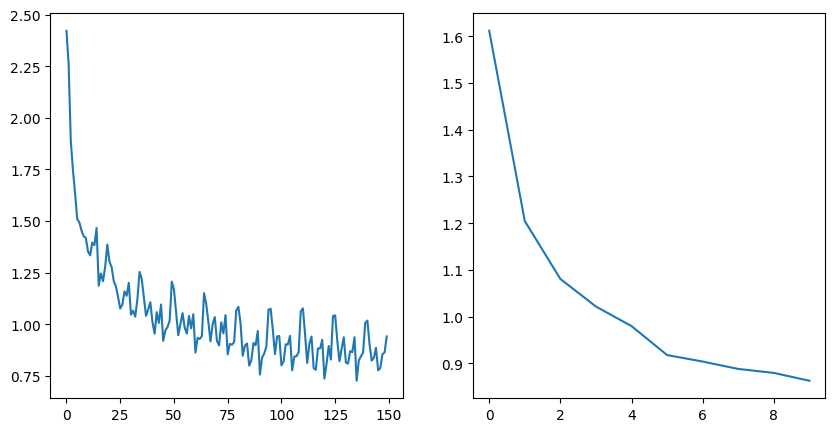

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

model_name = "UNet.pth"
root_path = ''
torch.save(model.state_dict(), root_path + model_name)

In [14]:
model_path = root_path + model_name
model_ = Unet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [15]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

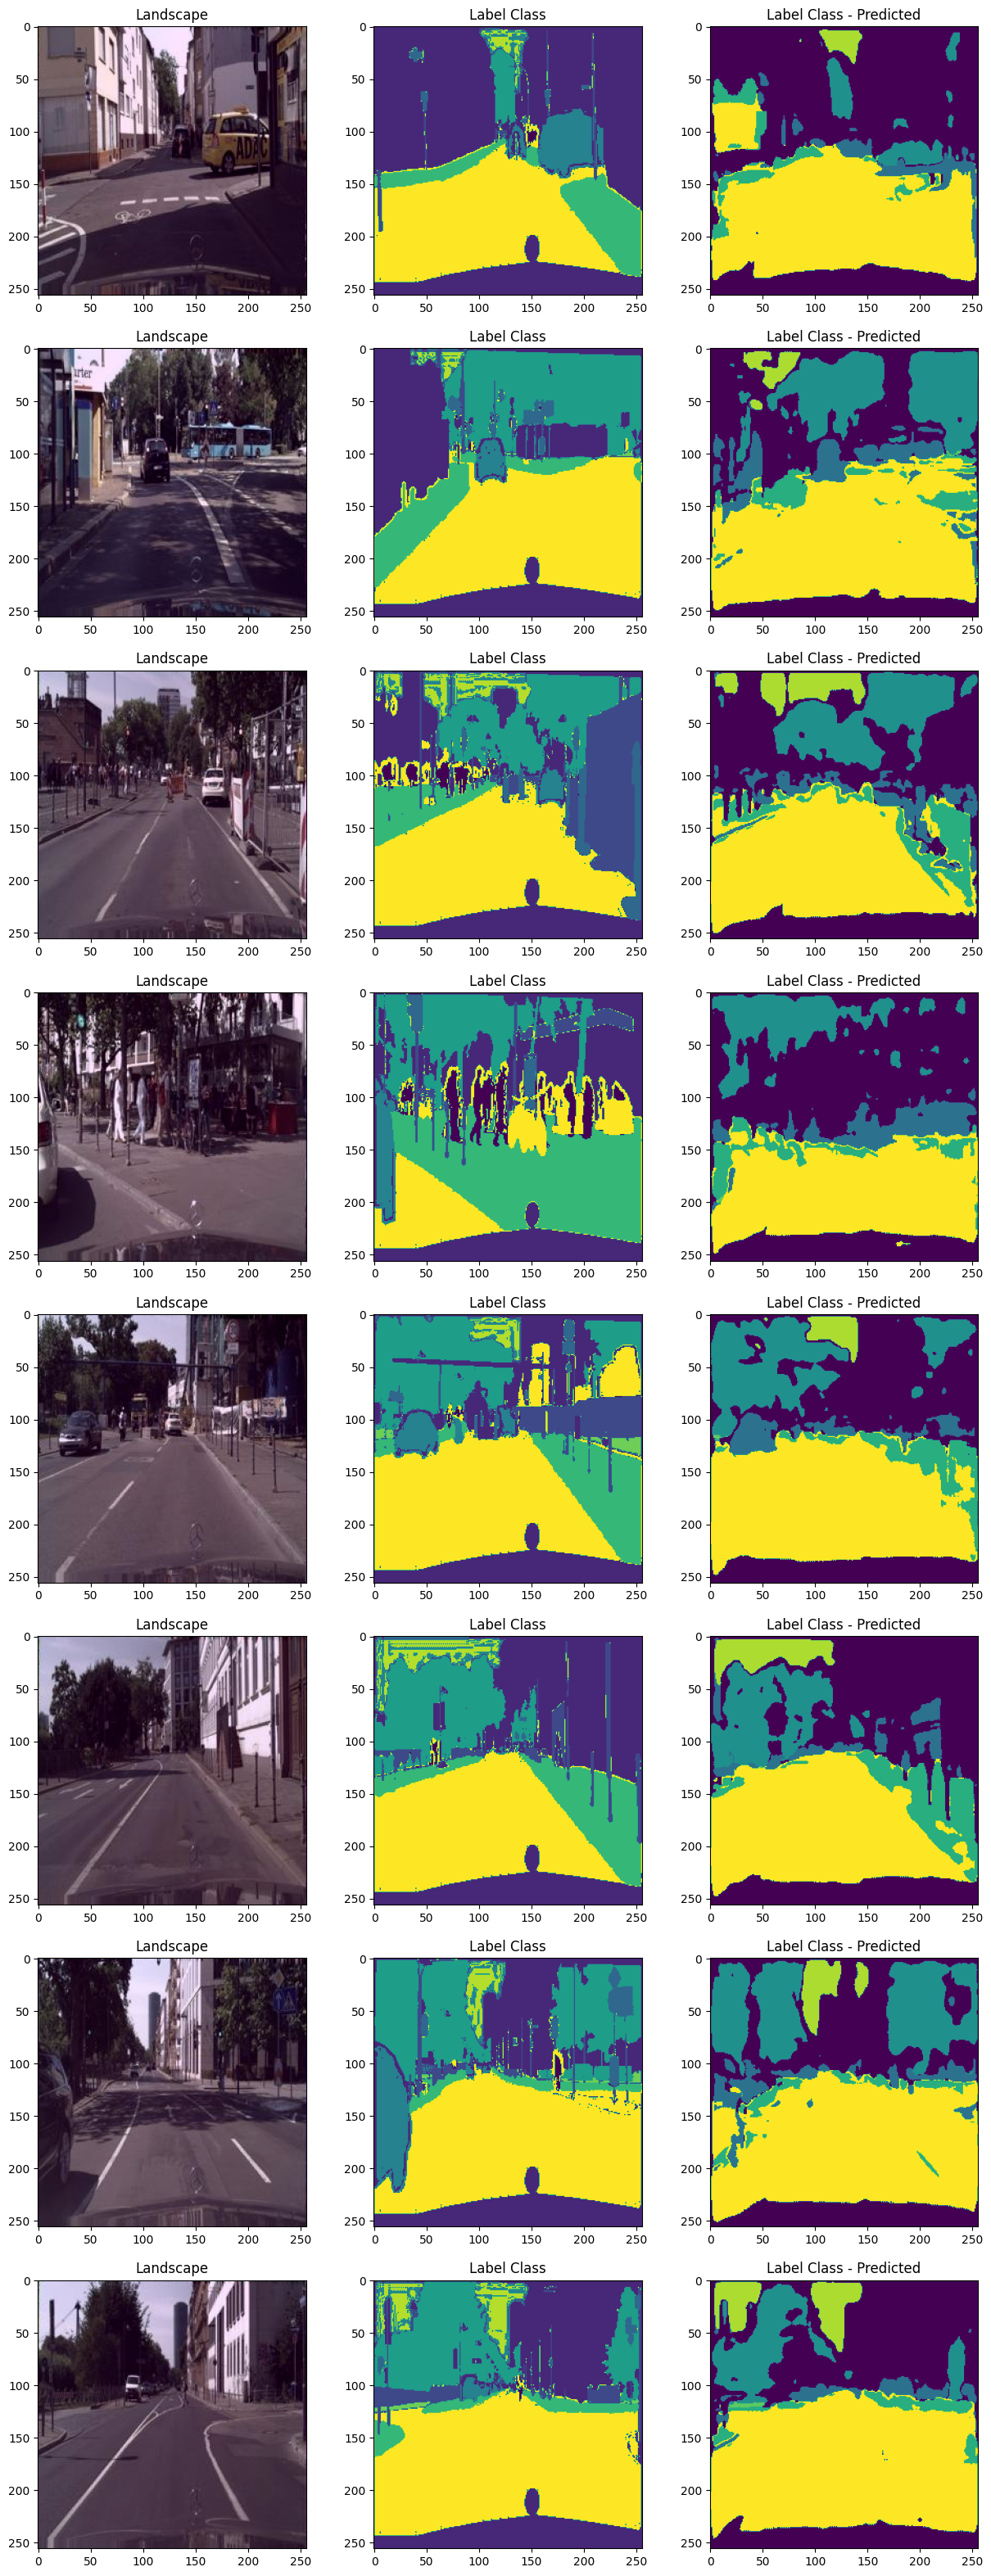

In [16]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [17]:
print(sum(iou_scores) / len(iou_scores))

0.9896697998046875


## 미러링 적용하는 함수

In [61]:
def tile_and_mirror(image, tile_size=256, overlap=64):
  """
  이미지를 중첩 타일로 분할하고, 각 타일의 경계에 미러링을 적용합니다.
  
  Parameters:
      image (numpy.ndarray): 입력 이미지 (H, W, C)
      tile_size (int): 타일의 크기 (정사각형 가정)
      overlap (int): 타일 간 중첩 영역의 크기
  
  Returns:
      List of tiled images with mirroring applied.
  """
  mirrored_tiles = []
  h, w, _ = image.shape
  stride = tile_size - overlap
  
  # 이미지를 타일로 분할
  for y in range(0, h, stride):
      for x in range(0, w, stride):
          # 타일 추출 및 경계 확인
          tile = image[y:min(y+tile_size, h), x:min(x+tile_size, w)]
          tile_h, tile_w, _ = tile.shape
          
          # 미러링 적용
          if tile_h < tile_size or tile_w < tile_size:
              tile = np.pad(tile, ((0, max(0, tile_size - tile_h)), 
                                    (0, max(0, tile_size - tile_w)), 
                                    (0, 0)), 
                            mode='reflect')
          
          mirrored_tiles.append(tile)
  
  return mirrored_tiles

## 예측된 결과들을 병합해서 최종 예측 이미지 생성하는 함수

In [62]:
def merge_tile_predictions(tiles, image_shape, tile_size=256, overlap=64):
    """
    예측된 타일들을 병합하여 최종 예측 이미지를 생성합니다.
    
    Parameters:
        tiles (List of numpy.ndarray): 예측된 타일들의 리스트
        image_shape (tuple): 원본 이미지의 형태 (H, W)
        tile_size (int): 타일의 크기
        overlap (int): 타일 간 중첩 영역의 크기
    
    Returns:
        numpy.ndarray: 병합된 최종 예측 이미지
    """
    h, w = image_shape
    stride = tile_size - overlap
    prediction = np.zeros((h, w), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)  # 중첩 카운트 맵
    
    i = 0
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            tile_prediction = tiles[i]
            i += 1
            
            # 중첩 영역 처리
            prediction[y:min(y+tile_size, h), x:min(x+tile_size, w)] += tile_prediction[:min(tile_size, h-y), :min(tile_size, w-x)]
            count_map[y:min(y+tile_size, h), x:min(x+tile_size, w)] += 1
    
    # 중첩 영역 평균 처리
    prediction /= count_map
    
    return prediction

## 실제 예측

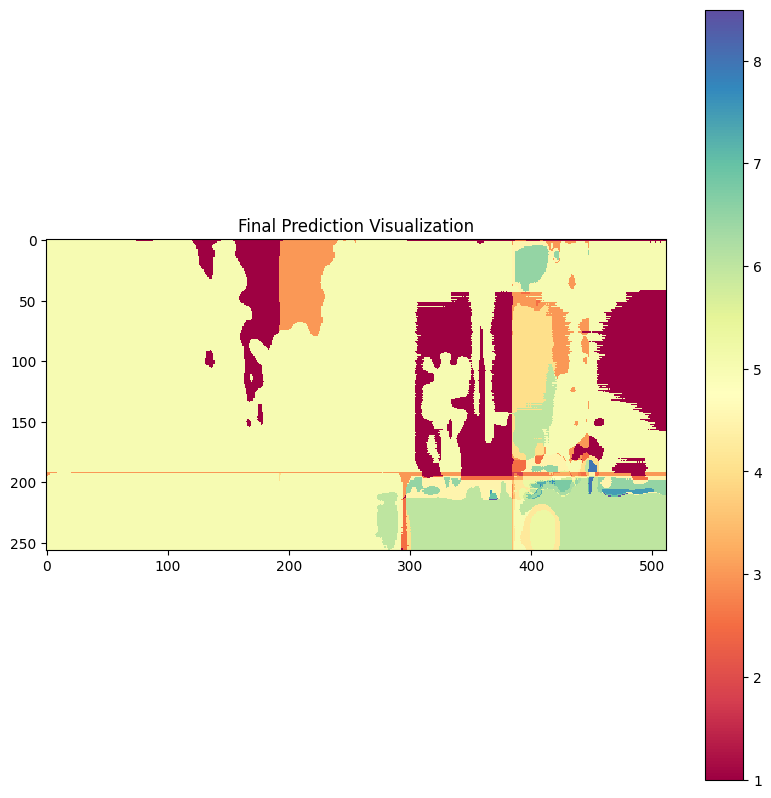

In [63]:
import torch
from torchvision import transforms
from torch.autograd import Variable

## 모델 예측을 위한 전처리 함수
def preprocess(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  ## 배치 차원 추가

## 모델의 예측 결과를 원래 이미지 크기로 변환하는 후처리 함수
def postprocess(tile_prediction):
    ## 예시: softmax 함수를 통과한 최대 확률을 가진 클래스 인덱스를 선택
    return torch.argmax(tile_prediction, dim=1).squeeze().cpu().numpy()

## 실제 모델을 사용한 예측 함수
def predict_with_tiling(image_path, model, tile_size=256, overlap=64):
    image = io.imread(image_path)  # 이미지 로드
    tiles = tile_and_mirror(image, tile_size, overlap)  ## 이미지를 타일로 분할 및 미러링 적용
    
    model.eval()  # 모델을 평가 모드로 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    predictions = []
    for tile in tiles:
        tile_input = preprocess(tile).to(device)
        with torch.no_grad():
            model_output = model(tile_input)
        tile_prediction = postprocess(model_output)
        predictions.append(tile_prediction)
    
    # 타일 예측 결과 병합
    final_prediction = merge_tile_predictions(predictions, image.shape[:2], tile_size, overlap)
    
    return final_prediction

# 이미지 경로와 훈련된 모델을 지정하여 함수 호출
image_path = 'train/10.jpg'
final_prediction = predict_with_tiling(image_path, model)

# 예측 결과 시각화
plt.figure(figsize=(10, 10))  # 이미지 크기 설정
plt.imshow(final_prediction, cmap='Spectral', interpolation='nearest')  # 예측 결과를 색상 맵 'jet'을 사용하여 표시
plt.colorbar()  # 색상 막대 추가
plt.title('Final Prediction Visualization')  # 그래프 제목 설정
plt.show()  # 그래프 표시